In [1]:
# !pip install -q transformers
#!pip install -U albumentations
# !pip install torchsummary
# !pip install torchinfo

In [88]:
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Normalize, ToTensor, ToPILImage
from torch.utils.data import Dataset
import pandas as pd
from torch.utils.data import DataLoader,random_split,Subset
from transformers import ViTForImageClassification

import numpy as np
from tqdm import tqdm
import datetime
import albumentations as A
import albumentations.pytorch as ATorch
from albumentations.augmentations.geometric.transforms import PadIfNeeded
from albumentations.augmentations.transforms import Normalize
from albumentations.augmentations.geometric.resize import Resize
import matplotlib.pyplot as plt
import cv2
import gc
import random
import os
import pickle
import sys

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [4]:
train_df = pd.read_csv("project_data/train.csv")

def get_frac_data_from_patient(target):
    patient_index = list(image_data.class_to_idx.values()).index(target)
    patient_name = list(image_data.class_to_idx.keys())[patient_index]
    row_for_pt = train_df[train_df["StudyInstanceUID"] == patient_name]
    return row_for_pt.iloc[:,1:].values


path = "project_data/project_analysis/sag"
image_data = ImageFolder(root=path, target_transform= get_frac_data_from_patient)
print(f"{len(image_data)} Samples")


16947 Samples


In [5]:
def get_image_shapes(dataset):
    tensor_t = ToTensor()
    shapes = []
    for sample in dataset:
        shapes.append(sample[0].size)
    return torch.Tensor(shapes)

In [6]:
def get_image_sequence(dataset):
    i = 0
    img_data_list = []
    for sample in random.sample(range(len(dataset)), len(dataset) // 4):
        # print(sample[0])
        img = dataset[sample]
        img_data = img[0].getdata()
        img_data_list.append(img_data)
        i += 1
        if i % 1000 == 0:
            print(i)
    return np.concatenate(img_data_list, axis=0) / 255

In [7]:
stat_file = 'image_stats.pickle'

if not os.path.exists(stat_file):
    print("Getting Shapes")
    shapes = get_image_shapes(image_data)
    print(f"Max Height: {torch.max(shapes[:,1])}, Max Width: {torch.max(shapes[:,0])}")
    print("Getting mean and std")
    data = get_image_sequence(image_data)
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    print(f"mean: {mean}, std:{std}")
    dataset_stats = {"mean": mean, "std": std, "shapes": shapes}
    with open(stat_file, 'wb') as f:
        pickle.dump(dataset_stats, f, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(stat_file, 'rb') as handle:
        dataset_stats = pickle.load(handle)

In [8]:
class ImageDataset(Dataset):
    def __init__(self, image_dataset, transform=None):
        self.image_data = image_dataset
        self.transform = transform

    def __len__(self):
        return len(self.image_data)

    def __getitem__(self, idx):
        image, label = self.image_data[idx]
        image = np.array(image)
        label = label.astype(np.float32)
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, np.squeeze(label)

In [9]:
base_augmentations = A.Compose([
    PadIfNeeded(int(torch.max(dataset_stats["shapes"][:,1]).item()), int(torch.max(dataset_stats["shapes"][:,0]).item())),
    A.Normalize(mean=dataset_stats["mean"].tolist(), std=dataset_stats["std"].tolist(), max_pixel_value=1),
    Resize(384,384),
    ATorch.transforms.ToTensorV2(),
])
    
image_dataset = ImageDataset(image_data, base_augmentations)

In [10]:
### Model Declaration

class ViTForMultiClassPrediction(nn.Module):
    def __init__(self):
        super(ViTForMultiClassPrediction, self).__init__()
        self.ViT = ViTForImageClassification.from_pretrained('google/vit-base-patch16-384', num_labels=8, ignore_mismatched_sizes=True)
        # Add Sigmoid for output between 0 and 1
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.ViT(x).logits
        x = self.sigmoid(x)
        return x

model = ViTForMultiClassPrediction()
model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-384 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForMultiClassPrediction(
  (ViT): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0): ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
           

In [11]:
# Train and Test functions (Taken from HW3 of CS7150 HWs)

# Train Function
def train_model(model, train_loader, device, loss_fn, optimizer):
    model.train()
    # Initiate a loss monitor
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning and not supervised classification)
    for i, (images, labels) in enumerate(train_loader): # the variable `labels` will be used for customised training
        # reshape input
        if (i % (len(train_loader) // 10) == 0):
            print(f"Completed {i} batches")
        optimizer.zero_grad()
        model.zero_grad()
        images = images.float()
        images = images.to(device)
        labels = labels.to(device)
        # predict the class
        predicted = model(images)
        loss = loss_fn(predicted, labels)
        # Backward pass (back propagation)
        loss.backward()
        optimizer.step()       
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss), train_loss

# Testing Function
def test_model(model, test_loader, device, loss_fn, input_dim=(-1,1,28,28)):
    # Set evaluation mode for encoder and decoder
    model.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        predicted = []
        actual = []
        for i, (images, labels) in enumerate(test_loader):
            # reshape input
            # images = torch.reshape(images,input_dim)
            if (i % (len(val_loader) // 5) == 0):
                print(f"Completed {i} batches")
            images = images.float()
            images = images.to(device)
            labels = labels.to(device)
            ## predict the label
            pred = model(images)
            # Append the network output and the original image to the lists
            predicted.append(pred.cpu())
            actual.append(labels.cpu())
        # Create a single tensor with all the values in the lists
        predicted = torch.cat(predicted)
        actual = torch.cat(actual) 
        # Evaluate global loss
        val_loss = loss_fn(predicted, actual)
    return val_loss.data, (predicted, actual)

In [12]:
### MODEL HYPERPARAMS
loss_fn = torch.nn.BCELoss()

lr=0.00003
num_epochs = 50
batch_size = 12
optim = torch.optim.Adam(model.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.LinearLR(optim)

### DATA PREPARATION
n_train_samples = len(image_data)
val_split = .15


train_data, val_data = random_split(image_dataset, [int(n_train_samples*(1-val_split))+1, int(n_train_samples*val_split)])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,shuffle=True, num_workers=0)

In [13]:
### Pytorch Native Train Loop

train = True

if train:
    print('ViT training started')
    history = {'train_loss':[],'val_loss':[], "batch_train_loss": []}
    start_time = datetime.datetime.now()
    folder_date = start_time.strftime("%Y_%m_%d_%H_%M_%S")

    model_ckpt_path = f"ViT_model_train_{folder_date}"

    if not os.path.exists(f"model_ckpts/{model_ckpt_path}"):
        os.mkdir(f"model_ckpts/{model_ckpt_path}")

    best_val_loss = 10**10

    for epoch in range(num_epochs):
        print(f"Epoch: {epoch}")    
        epoch_start_time = datetime.datetime.now()
        ### Training 
        print("Training Started")
        epoch_train_loss, batch_train_loss = train_model(
            model=model,
            train_loader=train_loader,
            device=device,
            loss_fn=loss_fn,
            optimizer=optim)
        ### Validation  (use the testing function)
        print("Validation Started")
        val_loss, predictions = test_model(
            model=model,
            test_loader=val_loader,
            device=device,
            loss_fn=loss_fn)
        lr_scheduler.step()
        # Print Losses 
        if (val_loss < best_val_loss):
            print(f"New Best Model with loss {val_loss}")
            torch.save(model.state_dict(), f"model_ckpts/{model_ckpt_path}/{epoch}_model_loss_{val_loss}.ckpt")
            best_val_loss = val_loss
        print(f'Epoch {epoch+1}/{num_epochs} : train loss {epoch_train_loss:.3f} \t val loss {val_loss:.3f}')
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(val_loss)
        history['batch_train_loss'].extend(batch_train_loss)
        with open(f"model_ckpts/{model_ckpt_path}/epoch_{epoch}_model_results.pickle", 'wb') as f:
            pickle.dump(history, f)
        print(f'Epoch {epoch} training done in {(datetime.datetime.now()-epoch_start_time).total_seconds():.3f} seconds!')



    with open(f"model_ckpts/{model_ckpt_path}/final_model_results.pickle", 'wb') as f:
        pickle.dump(history, f)

    print(f'ViT training done in {(datetime.datetime.now()-start_time).total_seconds():.3f} seconds!')

ViT training started
Epoch: 0
Training Started
Completed 0 batches
Completed 120 batches
Completed 240 batches
Completed 360 batches
Completed 480 batches
Completed 600 batches
Completed 720 batches
Completed 840 batches
Completed 960 batches
Completed 1080 batches
Completed 1200 batches
Validation Started
Completed 0 batches
Completed 42 batches
Completed 84 batches
Completed 126 batches
Completed 168 batches
Completed 210 batches
New Best Model with loss 0.3524111211299896
Epoch 1/50 : train loss 0.366 	 val loss 0.352
Epoch 0 training done in 984.439 seconds!
Epoch: 1
Training Started
Completed 0 batches
Completed 120 batches
Completed 240 batches
Completed 360 batches
Completed 480 batches
Completed 600 batches
Completed 720 batches
Completed 840 batches
Completed 960 batches
Completed 1080 batches
Completed 1200 batches
Validation Started
Completed 0 batches
Completed 42 batches
Completed 84 batches
Completed 126 batches
Completed 168 batches
Completed 210 batches
New Best Model w

KeyboardInterrupt: 

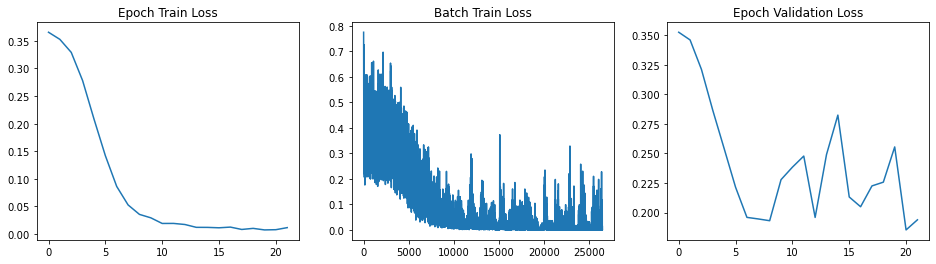

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16,4))

ax1.plot(history['train_loss'])
ax1.title.set_text('Epoch Train Loss')

ax2.plot(history['batch_train_loss'])
ax2.title.set_text('Batch Train Loss')

ax3.plot(history['val_loss'])
ax3.title.set_text('Epoch Validation Loss')

plt.savefig('vit_loss_graphs.png')


In [111]:
# Test Model

# test_df = pd.read_csv("project_data/train.csv")

# def get_frac_data_from_patient_test(target):
#     patient_index = list(image_data.class_to_idx.values()).index(target)
#     patient_name = list(image_data.class_to_idx.keys())[patient_index]
#     row_for_pt = test_df[train_df["StudyInstanceUID"] == patient_name]
#     return row_for_pt.iloc[:,1:].values

path = "project_data/project_analysis/sag_test"
image_data_test = ImageFolder(root=path, target_transform=lambda x: np.array([1,1,0,0,0,0,0,0]))
print(f"{len(image_data_test)} Samples")

image_dataset_test = ImageDataset(image_data_test, base_augmentations)

test_loader = torch.utils.data.DataLoader(image_dataset_test, batch_size=batch_size,shuffle=False, num_workers=0)

model = ViTForMultiClassPrediction()
model.load_state_dict(torch.load('model_ckpts/ViT_model_train_2022_12_04_16_39_24/8_model_loss_0.19310231506824493.ckpt'))
model.to(device)

test_loss, predictions = test_model(
    model=model,
    test_loader=test_loader,
    device=device,
    loss_fn=loss_fn)

303 Samples


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-384 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Completed 0 batches


In [112]:
pred_arr = predictions[0].numpy()
actual_arr = predictions[1].numpy()
thresholded_pred = np.where(pred_arr > 0.5, 1, 0)
correct = (thresholded_pred == actual_arr).all(axis=1).nonzero()[0]

for i,index in enumerate(correct):
    im = image_data_test[index][0]
    im.save(f'correct_vit_test_{i}.png')